In [9]:
import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import RMSE, RecurrentNetwork, TimeSeriesDataSet, Baseline, NHiTS, NBeats, RecurrentNetwork
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

scaler = MinMaxScaler()

In [10]:
train = pd.read_csv("data/train_dataset.csv", encoding='EUC-KR')
train['시간'] = pd.to_datetime(train['시간'])
train['time_idx'] = np.arange(len(train['시간']))
train['1시간평균 미세먼지농도(㎍/㎥)'] = train['1시간평균 미세먼지농도(㎍/㎥)'].interpolate()

train['1시간평균 미세먼지농도(㎍/㎥)'] = scaler.fit_transform(train[['1시간평균 미세먼지농도(㎍/㎥)']])

val = pd.read_csv("data/val_dataset.csv", encoding='EUC-KR')
val['시간'] = pd.to_datetime(val['시간'])
val['time_idx'] = np.arange(len(val['시간']))
val['1시간평균 미세먼지농도(㎍/㎥)'] = val['1시간평균 미세먼지농도(㎍/㎥)'].interpolate()
val['1시간평균 미세먼지농도(㎍/㎥)'] = scaler.transform(val[['1시간평균 미세먼지농도(㎍/㎥)']])

test = pd.read_csv("data/test_dataset.csv", encoding='EUC-KR')
test['시간'] = pd.to_datetime(test['시간'])
test['time_idx'] = np.arange(len(test['시간']))
test['1시간평균 미세먼지농도(㎍/㎥)'] = test['1시간평균 미세먼지농도(㎍/㎥)'].interpolate()
test['1시간평균 미세먼지농도(㎍/㎥)'] = scaler.transform(test[['1시간평균 미세먼지농도(㎍/㎥)']])


print(len(train), len(val), len(test))
total = len(train) + len(val) + len(test)
print(len(train)/total, len(val)/total, len(test)/total)

25963 8782 8713
0.5974274011689448 0.20208016935892126 0.20049242947213403


In [11]:
encoding_length = 24
prediction_length = 24

training = TimeSeriesDataSet(
    train,
    time_idx="time_idx",
    target="1시간평균 미세먼지농도(㎍/㎥)",
    group_ids=["지점"],
    time_varying_unknown_reals=["1시간평균 미세먼지농도(㎍/㎥)"],
    max_encoder_length=encoding_length,
    max_prediction_length=prediction_length,
    target_normalizer=None,
)

validation = TimeSeriesDataSet.from_dataset(training, val, predict=False, stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(training, test, predict=False, stop_randomization=True)

batch_size = 64

train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=4, shuffle=False,
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, shuffle=False,
)
test_dataloader = testing.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, shuffle=False,
)

In [12]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    enable_model_summary=False,
    enable_progress_bar=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
)


net = NBeats.from_dataset(
    training,
    learning_rate=0.01,
    widths=[256, 2048],
    backcast_loss_ratio=1.0,
    weight_decay=1e-2,
    loss=RMSE()
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

C:\Users\quant\Anaconda3\envs\speaker-hackerton2022\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\quant\Anaconda3\envs\speaker-hackerton2022\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (RMSE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an c

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [14]:
raw_predictions = best_model.predict(test_dataloader, mode="raw", )
raw_predictions['prediction']

tensor([[0.0512, 0.0578, 0.0594,  ..., 0.1021, 0.1031, 0.1068],
        [0.0571, 0.0624, 0.0632,  ..., 0.1018, 0.1029, 0.1059],
        [0.0685, 0.0722, 0.0715,  ..., 0.1037, 0.1050, 0.1076],
        ...,
        [0.0537, 0.0610, 0.0625,  ..., 0.1042, 0.1019, 0.1050],
        [0.0480, 0.0536, 0.0547,  ..., 0.1034, 0.1027, 0.1052],
        [0.0386, 0.0417, 0.0425,  ..., 0.1043, 0.1062, 0.1088]])

In [15]:
ind = 0

predicted = scaler.inverse_transform(raw_predictions['prediction'].squeeze().numpy())
observed = scaler.inverse_transform(test[['1시간평균 미세먼지농도(㎍/㎥)']])
r2 = r2_score(observed[encoding_length:8666+encoding_length,], predicted[:,0])
rmse = np.sqrt(mean_squared_error(observed[encoding_length:8666+encoding_length,], predicted[:,0]))

print(r2, rmse)

0.8104938166727803 11.266136545704661


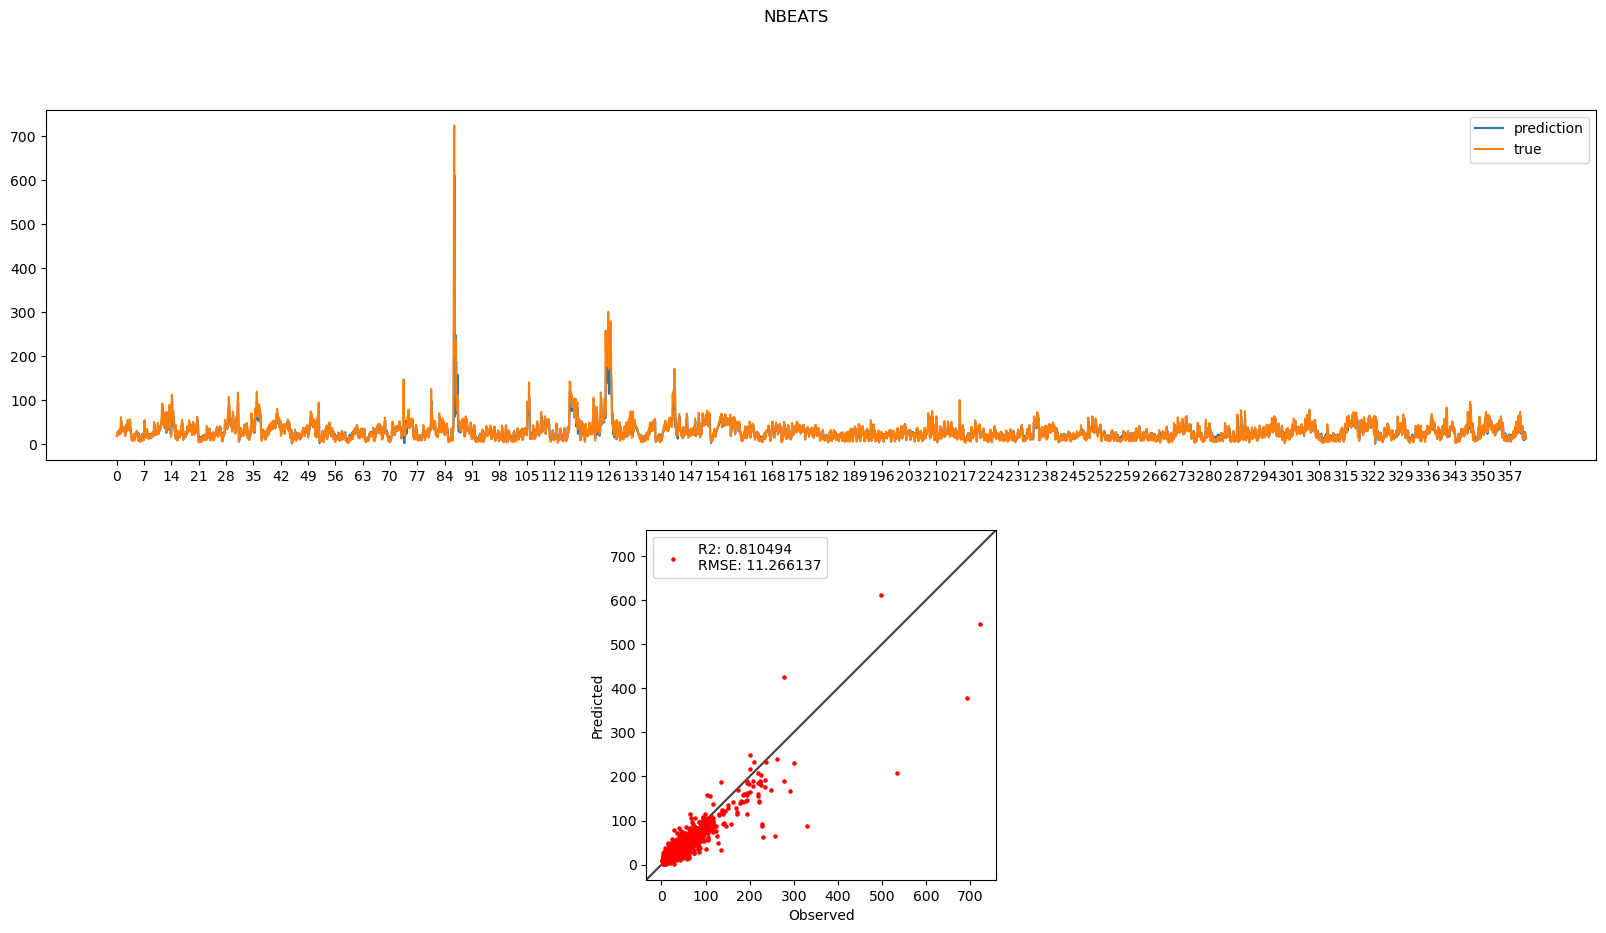

In [17]:
import datetime
fig, ax = plt.subplots(2)
fig.suptitle('NBEATS')
ax[0].set_xticks(np.arange(0, 8666, 24 * 7), np.arange(0, 364, 7))
ax[0].plot(predicted[:,ind], label='prediction')
ax[0].plot(observed[encoding_length:8666+encoding_length,], label= 'true')

ax[0].legend()

ax[1].scatter(
    observed[encoding_length+ind:8666+encoding_length+ind,], predicted[:,ind], s=5, c="r", label='R2: %f\nRMSE: %f' %(r2, rmse)
)

lims = [
    np.min([ax[1].get_xlim(), ax[1].get_ylim()]),
    np.max([ax[1].get_xlim(), ax[1].get_ylim()]),
]
ax[1].plot(lims, lims, "k-", alpha=0.75, zorder=0)
ax[1].set_aspect("equal")
ax[1].set_xlim(lims)
ax[1].set_ylim(lims)
ax[1].set_xlabel("Observed")
ax[1].set_ylabel("Predicted")
ax[1].legend()
plt.savefig("img/nbeats.png")